# Preprocessing Data

In [1]:
!git clone https://gitlab.com/shimorina/webnlg-dataset.git

Cloning into 'webnlg-dataset'...
remote: Enumerating objects: 5112, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 5112 (delta 2), reused 0 (delta 0), pack-reused 5106 (from 1)
Receiving objects: 100% (5112/5112), 26.09 MiB | 21.03 MiB/s, done.
Resolving deltas: 100% (4010/4010), done.
Updating files: 100% (1425/1425), done.


In [2]:
!git clone https://github.com/WebNLG/webnlg_toolkit.git
%cd webnlg_toolkit
%ls
!pip install -e .

Cloning into 'webnlg_toolkit'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 230 (delta 45), reused 211 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (230/230), 16.78 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/webnlg_toolkit
LICENSE  README.md  requirements.txt  setup.py  webnlg_toolkit/
Obtaining file:///content/webnlg_toolkit
  Preparing metadata (setup.py) ... done
  Running setup.py develop for webnlg_toolkit


In [3]:
import spacy
import re
from collections import defaultdict

In [4]:
nlp = spacy.load("en_core_web_sm")

In [27]:
import random

In [5]:
import os
import glob
import json
import numpy as np
import pandas as pd
import torch
import re
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    AdamW,
    get_linear_schedule_with_warmup
)
!pip install datasets
from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import webnlg_toolkit
from webnlg_toolkit.utils.data import load_webnlg_dataset
from webnlg_toolkit.utils.data import load_webnlg_xml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.7 MB/s eta 0:00:00


In [6]:
# Define paths
#dataset_root = "/content/drive/MyDrive/en/train/"
#test_root = "/content/drive/MyDrive/en/dev/"

dataset_root = "/content/webnlg-dataset/release_v3.0/en/train/"
test_root = "/content/webnlg-dataset/release_v3.0/en/dev/"

# Function to find dataset files
def find_dataset_files(root_folder, file_extension=".xml"):
    dataset_files = []
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith(file_extension):
                dataset_files.append(os.path.join(subdir, file))
    return dataset_files

# Load training data
def load_all_data(root_folder):
    dataset_files = find_dataset_files(root_folder, file_extension=".xml")
    all_data = []
    for file in dataset_files:
        print(f"Loading: {file}")
        data = load_webnlg_dataset(file, task="rdf2text")
        # print(data)
        all_data.extend(data)
    return all_data

# Load training and test data
train_data = load_all_data(dataset_root)
test_data = load_all_data(test_root)

# Convert to DataFrames
train_df = pd.DataFrame(train_data, columns=["input", "output"])
test_df = pd.DataFrame(test_data, columns=["input", "output"])
print(f"Training examples: {len(train_df)}")
print(f"Test examples: {len(test_df)}")

# Display some examples
print("\nTraining examples:")
print(train_df.head(3))

print("\nTest examples:")
print(test_df.head(3))

Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/CelestialBody_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/MeanOfTransportation_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Athlete_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Food_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Astronaut_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/University_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Artist_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/City_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/WrittenWork_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Company_allSolutions.xml
Loading: /content/webnlg-dataset/release_v3.0/en/train/1triples/Politician_allSolutions.x

In [7]:
def extract_relations(input_text):
    """Extract relation types from input text in the format <S> entity1 <P> relation <O> entity2"""
    relations = []
    pattern = r'<P>\s+(.*?)\s+<O>'
    matches = re.findall(pattern, input_text)
    return matches

# Apply relation extraction to create a new column with relation types
train_df['relations'] = train_df['input'].apply(extract_relations)
test_df['relations'] = test_df['input'].apply(extract_relations)


In [8]:
def extract_entities(input_text):
    """Extract entity pairs from input text in the format <S> entity1 <P> relation <O> entity2"""
    entity_pairs = []
    pattern = r'<S>\s+(.*?)\s+<P>.*?<O>\s+(.*?)(?:\n|$)'
    matches = re.findall(pattern, input_text)
    return matches

# Apply entity extraction to create a new column with entity pairs
train_df['entity_pairs'] = train_df['input'].apply(extract_entities)
test_df['entity_pairs'] = test_df['input'].apply(extract_entities)


In [9]:
def get_entity_type(entity_text):
    """
    Determine entity type using SpaCy NER and heuristics.
    Returns one of: PERSON, LOCATION, ORGANIZATION, DATE, MISC
    """
    # Process with SpaCy
    doc = nlp(entity_text)

    # Check if SpaCy found any entities
    if doc.ents:
        # Get the most common entity type
        ent_type = doc.ents[0].label_

        # Map SpaCy entity types to our simplified types
        if ent_type in ["PERSON", "PER"]:
            return "PERSON"
        elif ent_type in ["LOC", "GPE", "FAC"]:
            return "LOCATION"
        elif ent_type in ["ORG"]:
            return "ORGANIZATION"
        elif ent_type in ["DATE", "TIME"]:
            return "DATE"

    # Use heuristics as backup
    lower_text = entity_text.lower()

    # Check for locations
    location_words = ["city", "country", "state", "river", "mountain", "ocean", "sea", "lake"]
    if any(word in lower_text for word in location_words):
        return "LOCATION"

    # Check for organizations
    org_indicators = ["inc", "corp", "llc", "company", "association", "university", "institute"]
    if any(word in lower_text for word in org_indicators):
        return "ORGANIZATION"

    # Check for date patterns
    if re.search(r'\b(19|20)\d{2}\b', entity_text) or \
       re.search(r'\b(January|February|March|April|May|June|July|August|September|October|November|December)\b', entity_text, re.IGNORECASE):
        return "DATE"

    # Default to MISC
    return "MISC"

In [10]:
all_relations = []
for relations in train_df['relations']:
    all_relations.extend(relations)
unique_relations = sorted(list(set(all_relations)))
relation_to_id = {relation: idx for idx, relation in enumerate(unique_relations)}
id_to_relation = {idx: relation for relation, idx in relation_to_id.items()}

print(f"\nNumber of unique relation types: {len(unique_relations)}")
print("Example relation types:", unique_relations[:5])


Number of unique relation types: 372
Example relation types: ['1st runway length feet', '1st runway length metre', '1st runway number', '1st runway surface type', '2nd runway surface type']


In [11]:
class ContentAwareRelationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, entity_markers, entity_end_markers, max_length=128, relation_to_id=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.relation_to_id = relation_to_id
        self.entity_markers = entity_markers
        self.entity_end_markers = entity_end_markers

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Get relation and entity pair
        relation = row['relations'][0] if len(row['relations']) > 0 else "unknown"
        entity_pair = row['entity_pairs'][0] if len(row['entity_pairs']) > 0 else ("", "")
        entity1, entity2 = entity_pair

        # Get context (use output text if available)
        context = row.get('output', "")

        # Determine entity types
        entity1_type = get_entity_type(entity1)
        entity2_type = get_entity_type(entity2)

        # Get type-specific markers
        e1_start = self.entity_markers.get(entity1_type, self.entity_markers["DEFAULT"])
        e1_end = self.entity_end_markers.get(entity1_type, self.entity_end_markers["DEFAULT"])

        e2_start = self.entity_markers.get(entity2_type, self.entity_markers["DEFAULT"])
        e2_end = self.entity_end_markers.get(entity2_type, self.entity_end_markers["DEFAULT"])

        # Format with type-specific markers
        if context:
            # Try to find entities in context
            formatted_text = context

            # Escape regex special characters in entities
            e1_esc = re.escape(entity1)
            e2_esc = re.escape(entity2)

            # Replace entities with marked versions - handle longer entity first to avoid substring issues
            if len(entity1) >= len(entity2):
                formatted_text = re.sub(f"\\b{e1_esc}\\b", f"{e1_start} {entity1} {e1_end}", formatted_text)
                formatted_text = re.sub(f"\\b{e2_esc}\\b", f"{e2_start} {entity2} {e2_end}", formatted_text)
            else:
                formatted_text = re.sub(f"\\b{e2_esc}\\b", f"{e2_start} {entity2} {e2_end}", formatted_text)
                formatted_text = re.sub(f"\\b{e1_esc}\\b", f"{e1_start} {entity1} {e1_end}", formatted_text)

            # If entities weren't found in context, append them with markers
            if e1_start not in formatted_text:
                formatted_text += f" {e1_start} {entity1} {e1_end}"
            if e2_start not in formatted_text:
                formatted_text += f" {e2_start} {entity2} {e2_end}"
        else:
            # No context - just use the marked entities
            formatted_text = f"{e1_start} {entity1} {e1_end} {e2_start} {entity2} {e2_end}"

        # Tokenize
        encoding = self.tokenizer(
            formatted_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove batch dimension
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}

        # Add relation label
        if self.relation_to_id:
            relation_id = self.relation_to_id.get(relation, 0)
            encoding['labels'] = torch.tensor(relation_id, dtype=torch.long)

        return encoding

In [12]:
# Define entity type markers
entity_markers = {
    "PERSON": "[PERSON]",
    "LOCATION": "[LOCATION]",
    "ORGANIZATION": "[ORG]",
    "DATE": "[DATE]",
    "MISC": "[MISC]",
    "DEFAULT": "[ENTITY]"
}

entity_end_markers = {
    "PERSON": "[/PERSON]",
    "LOCATION": "[/LOCATION]",
    "ORGANIZATION": "[/ORG]",
    "DATE": "[/DATE]",
    "MISC": "[/MISC]",
    "DEFAULT": "[/ENTITY]"
}

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Add special tokens for entity markers
special_tokens = list(entity_markers.values()) + list(entity_end_markers.values())
special_tokens_dict = {'additional_special_tokens': special_tokens}
tokenizer.add_special_tokens(special_tokens_dict)

print(f"Added {len(special_tokens)} special tokens to tokenizer")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Added 12 special tokens to tokenizer


In [13]:
# Create datasets
train_dataset = ContentAwareRelationDataset(
    train_df,
    tokenizer,
    entity_markers,
    entity_end_markers,
    max_length=128,
    relation_to_id=relation_to_id
)
test_dataset = ContentAwareRelationDataset(
    test_df,
    tokenizer,
    entity_markers,
    entity_end_markers,
    max_length=128,
    relation_to_id=relation_to_id
)

# Split training data into train and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator1)

print(f"\nTraining set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 31883
Validation set size: 3543
Test set size: 4464


# Editing Model Parameters

## Dropout Setting & Bias Correction

In [14]:
# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Set the dropout rate (for both attention and hidden layers)
dropout_rate = 0.1  # Set this to your desired dropout rate (e.g., 0.3)

# Initialize model with modified dropout rates
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_relations),
    hidden_dropout_prob=dropout_rate,        # Dropout rate for hidden layers
    attention_probs_dropout_prob=dropout_rate # Dropout rate for attention layers
)
model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(30534, 768, padding_idx=0)

In [15]:
# Define the betas for bias correction
beta1 = 0.9  # First moment estimate bias correction
beta2 = 0.999  # Second moment estimate bias correction

# Initialize AdamW optimizer with bias correction
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,  # learning rate
    betas=(beta1, beta2),  # Specify betas for bias correction
    eps=1e-8,  # A small value to prevent division by zero
    weight_decay=0.01  # Optional, weight decay for regularization
)

# Set up the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30534, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Training Model

In [16]:
# Number of training epochs
num_epochs = 9
#num_epochs = 2
total_steps = len(train_loader) * num_epochs

# Create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [17]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    return total_loss / len(dataloader)

In [18]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=-1)

            total_loss += loss.item()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(dataloader), accuracy, f1, all_preds, all_labels

In [19]:
# Training loop
print("\nStarting training...")
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_loss, val_accuracy, val_f1, _, _ = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    print(f"Train loss: {train_loss:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 score: {val_f1:.4f}")


Starting training...

Epoch 1/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 3.0743
Validation loss: 1.7069
Validation accuracy: 0.7135
Validation F1 score: 0.6269

Epoch 2/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 1.3243
Validation loss: 0.9443
Validation accuracy: 0.8498
Validation F1 score: 0.8084

Epoch 3/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.7927
Validation loss: 0.6185
Validation accuracy: 0.9060
Validation F1 score: 0.8822

Epoch 4/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.5349
Validation loss: 0.4575
Validation accuracy: 0.9308
Validation F1 score: 0.9153

Epoch 5/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.3952
Validation loss: 0.3611
Validation accuracy: 0.9447
Validation F1 score: 0.9316

Epoch 6/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.3101
Validation loss: 0.3050
Validation accuracy: 0.9495
Validation F1 score: 0.9380

Epoch 7/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.2574
Validation loss: 0.2755
Validation accuracy: 0.9534
Validation F1 score: 0.9438

Epoch 8/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.2256
Validation loss: 0.2604
Validation accuracy: 0.9560
Validation F1 score: 0.9477

Epoch 9/9


Training:   0%|          | 0/1993 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/222 [00:00<?, ?it/s]

Train loss: 0.2096
Validation loss: 0.2528
Validation accuracy: 0.9568
Validation F1 score: 0.9490



Model saved to /content/bert_relation_extraction.pt


Text(0.5, 0, 'Epoch')

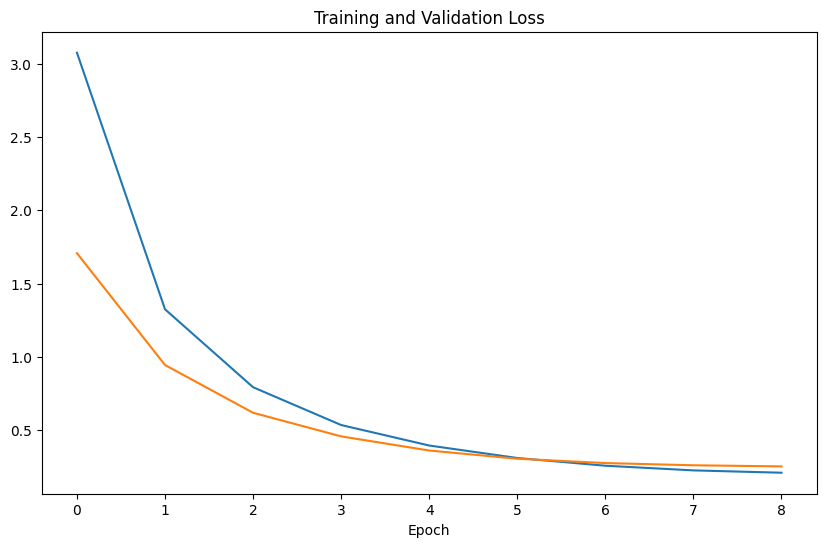

In [20]:
# Save the model
model_save_path = "/content/bert_relation_extraction.pt"
torch.save(model.state_dict(), model_save_path)
print(f"\nModel saved to {model_save_path}")

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

In [21]:
# Add after evaluation
def analyze_performance_by_entity_types(model, dataloader, id_to_relation, device):
    """Analyze model performance based on entity type combinations"""
    model.eval()

    # Track performance by entity type pairs
    results = defaultdict(lambda: {'correct': 0, 'total': 0})

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Analyzing"):
            batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

            # Get input tokens
            input_ids = batch['input_ids']
            labels = batch['labels']

            # Forward pass
            outputs = model(**batch)
            predictions = torch.argmax(outputs.logits, dim=1)

            # Analyze each example in batch
            for i in range(input_ids.size(0)):
                # Convert tokens back to text
                tokens = tokenizer.convert_ids_to_tokens(input_ids[i])
                text = tokenizer.convert_tokens_to_string(tokens)

                # Extract entity types from markers
                entity_types = []
                for marker in entity_markers.values():
                    if marker in text:
                        entity_type = marker.strip('[]')
                        entity_types.append(entity_type)

                # If we found two entity types, record performance
                if len(entity_types) >= 2:
                    entity_pair = tuple(sorted(entity_types[:2]))
                    is_correct = predictions[i].item() == labels[i].item()

                    results[entity_pair]['total'] += 1
                    if is_correct:
                        results[entity_pair]['correct'] += 1

    # Calculate accuracy for each entity type pair
    print("\nPerformance by Entity Type Pair:")
    for entity_pair, stats in results.items():
        accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
        print(f"{entity_pair}: {accuracy:.4f} ({stats['correct']}/{stats['total']})")

    return results

In [22]:
def predict_relation_with_types(entity1, entity2, model, tokenizer, id_to_relation, device):
    """Predict relation between two entities with type-aware markers"""
    model.eval()

    # Get entity types
    entity1_type = get_entity_type(entity1)
    entity2_type = get_entity_type(entity2)

    # Get type markers
    e1_start = entity_markers.get(entity1_type, entity_markers["DEFAULT"])
    e1_end = entity_end_markers.get(entity1_type, entity_end_markers["DEFAULT"])

    e2_start = entity_markers.get(entity2_type, entity_markers["DEFAULT"])
    e2_end = entity_end_markers.get(entity2_type, entity_end_markers["DEFAULT"])

    # Format input with type markers
    formatted_text = f"{e1_start} {entity1} {e1_end} {e2_start} {entity2} {e2_end}"

    # Tokenize
    inputs = tokenizer(
        formatted_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)[0]
        prediction = torch.argmax(logits, dim=1).item()

    # Get relation and confidence
    relation = id_to_relation[prediction]
    confidence = probabilities[prediction].item()

    # Get top 3 predictions
    top_probs, top_indices = torch.topk(probabilities, min(3, len(id_to_relation)))

    print(f"Entity 1: {entity1} (Type: {entity1_type})")
    print(f"Entity 2: {entity2} (Type: {entity2_type})")
    print(f"Predicted relation: {relation} (Confidence: {confidence:.4f})")
    print("\nTop predictions:")

    for i, idx in enumerate(top_indices):
        rel = id_to_relation[idx.item()]
        prob = top_probs[i].item()
        print(f"  {rel}: {prob:.4f}")

    return relation, confidence

In [23]:
# After training completes, analyze performance by entity types
print("\nAnalyzing test performance by entity types...")
entity_type_results = analyze_performance_by_entity_types(model, test_loader, id_to_relation, device)

# Try some examples
print("\nTesting specific examples:")
examples = [
    ("Barack Obama", "United States"),
    ("Apple", "iPhone"),
    ("Paris", "France"),
    ("Albert Einstein", "1955")
]

for entity1, entity2 in examples:
    print("\n" + "="*50)
    predict_relation_with_types(entity1, entity2, model, tokenizer, id_to_relation, device)


Analyzing test performance by entity types...


Analyzing:   0%|          | 0/279 [00:00<?, ?it/s]


Performance by Entity Type Pair:
('DATE', 'PERSON'): 0.8585 (91/106)
('DATE', 'MISC'): 0.9859 (140/142)
('MISC', 'PERSON'): 0.9597 (691/720)
('LOCATION', 'PERSON'): 0.9747 (462/474)
('DATE', 'ORG'): 0.9072 (88/97)
('LOCATION', 'ORG'): 0.9688 (311/321)
('ORG', 'PERSON'): 0.9515 (549/577)
('MISC', 'ORG'): 0.9620 (304/316)
('LOCATION', 'MISC'): 0.9636 (476/494)
('DATE', 'LOCATION'): 1.0000 (18/18)

Testing specific examples:

Entity 1: Barack Obama (Type: PERSON)
Entity 2: United States (Type: LOCATION)
Predicted relation: leader (Confidence: 0.9826)

Top predictions:
  leader: 0.9826
  party: 0.0045
  anthem: 0.0008

Entity 1: Apple (Type: ORGANIZATION)
Entity 2: iPhone (Type: MISC)
Predicted relation: manufacturer (Confidence: 0.7466)

Top predictions:
  manufacturer: 0.7466
  dish variation: 0.0403
  related mean of transportation: 0.0317

Entity 1: Paris (Type: LOCATION)
Entity 2: France (Type: LOCATION)
Predicted relation: country (Confidence: 0.9651)

Top predictions:
  country: 0.

# Loading Pre trained model

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Initialize model with the same architecture
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_relations)
)

# Load the saved weights
model_save_path = "/content/bert_relation_extraction.pt"
model.load_state_dict(torch.load(model_save_path))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-33a8c6a0dea3>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

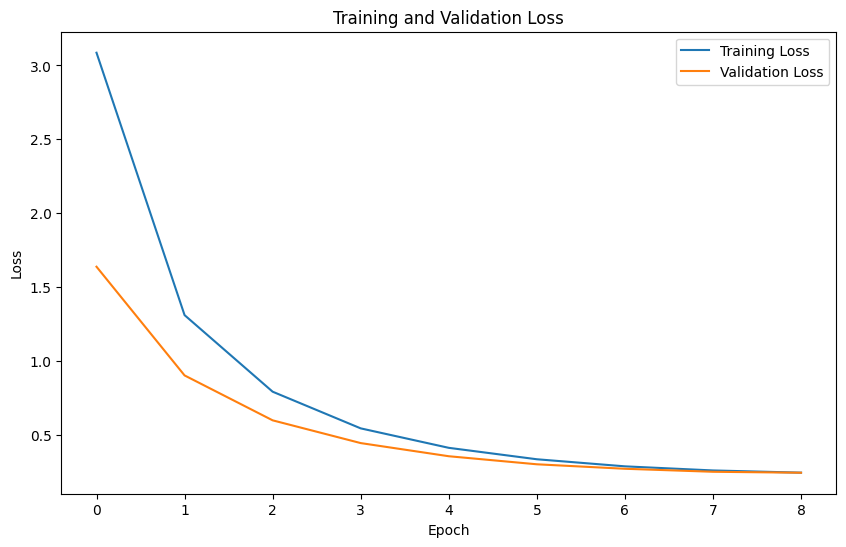

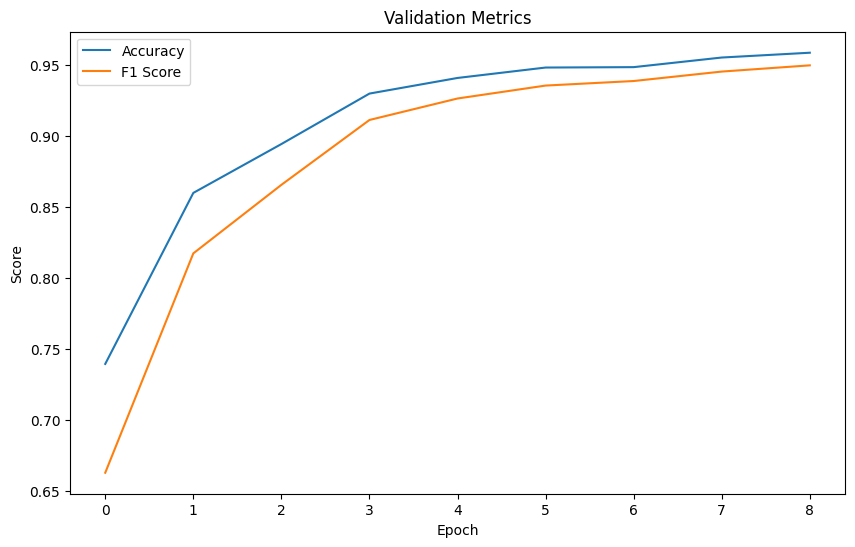

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/loss_plot.png')

# Plot validation accuracy and F1 score
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Accuracy')
plt.plot(val_f1_scores, label='F1 Score')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
#plt.savefig('/content/drive/MyDrive/metrics_plot.png')


In [ ]:
# Final evaluation on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy, test_f1, test_preds, test_labels = evaluate(model, test_loader, device)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test F1 score: {test_f1:.4f}")


Evaluating on test set...


Evaluating:   0%|          | 0/279 [00:00<?, ?it/s]

Test loss: 0.3997
Test accuracy: 0.9270
Test F1 score: 0.9174


In [ ]:
unique_test_labels = sorted(set(test_labels))  # Extract only present relation IDs
target_names = [id_to_relation[i] for i in unique_test_labels]  # Filter relation names
print(classification_report(test_labels, test_preds, labels=unique_test_labels, target_names=target_names))

                                                   precision    recall  f1-score   support

                          1st runway surface type       0.60      1.00      0.75         3
                          2nd runway surface type       0.00      0.00      0.00         3
                          3rd runway surface type       0.73      1.00      0.84         8
                          4th runway surface type       0.00      0.00      0.00         2
                                     abbreviation       0.80      1.00      0.89        20
                              academic discipline       1.00      0.62      0.76        13
                              academic staff size       1.00      0.82      0.90        17
                            active years end date       1.00      1.00      1.00         1
                          active years start date       1.00      0.43      0.60         7
                          active years start year       0.57      0.67      0.62         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Create a function for real-time inference
def extract_relation(entity1, entity2, text=None):
    """
    Extract relation between two entities using the trained model.

    Args:
        entity1 (str): First entity
        entity2 (str): Second entity
        text (str, optional): Context text containing the entities

    Returns:
        str: Predicted relation type
    """
    # Prepare input for the model
    encoding = tokenizer(
        entity1,
        entity2,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )

    # Move to device
    encoding = {k: v.to(device) for k, v in encoding.items()}

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    # Get relation type
    relation = id_to_relation.get(prediction, "unknown")

    return relation

# Implementing an SVM

In [ ]:
# Method 2: Traditional ML approach (SVM) for comparison
print("\nImplementing Method 2: Traditional ML Approach")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


Implementing Method 2: Traditional ML Approach


In [ ]:
# Create a simplified dataset for SVM
def prepare_data_for_svm(df):
    X = []
    y = []

    for _, row in df.iterrows():
        if len(row['entity_pairs']) > 0 and len(row['relations']) > 0:
            entity1, entity2 = row['entity_pairs'][0]
            relation = row['relations'][0]

            # Create a simple text representation
            text = f"{entity1} {entity2}"

            X.append(text)
            y.append(relation)

    return X, y

In [ ]:
# Prepare data
X_train, y_train = prepare_data_for_svm(train_df)
X_test, y_test = prepare_data_for_svm(test_df)

print(f"SVM training examples: {len(X_train)}")
print(f"SVM test examples: {len(X_test)}")

# Create SVM pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svm', SVC(kernel='linear', probability=True))
])

SVM training examples: 35426
SVM test examples: 4464


In [ ]:
# Train SVM
print("Training SVM model...")
svm_pipeline.fit(X_train, y_train)

Training SVM model...


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('svm', SVC(kernel='linear', probability=True))])

In [ ]:
# Evaluate SVM
svm_preds = svm_pipeline.predict(X_test)
svm_accuracy = (svm_preds == y_test).mean()
svm_f1 = f1_score(y_test, svm_preds, average='weighted')

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM F1 Score: {svm_f1:.4f}")


SVM Accuracy: 0.9082
SVM F1 Score: 0.9011


In [ ]:
# Classification report for SVM
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_preds))


SVM Classification Report:
                                                   precision    recall  f1-score   support

                                1st runway number       0.00      0.00      0.00         0
                          1st runway surface type       1.00      1.00      1.00         3
                          2nd runway surface type       0.00      0.00      0.00         3
                          3rd runway surface type       0.73      1.00      0.84         8
                          4th runway surface type       1.00      1.00      1.00         2
                                     abbreviation       0.71      1.00      0.83        20
                              academic discipline       1.00      0.62      0.76        13
                              academic staff size       1.00      0.82      0.90        17
                            active years end date       1.00      1.00      1.00         1
                          active years start date       1.00 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
# Function for SVM real-time inference
def svm_extract_relation(entity1, entity2):
    """
    Extract relation between two entities using the trained SVM model.

    Args:
        entity1 (str): First entity
        entity2 (str): Second entity

    Returns:
        str: Predicted relation type
    """
    # Create input text
    text = f"{entity1} {entity2}"

    # Make prediction
    prediction = svm_pipeline.predict([text])[0]

    return prediction

In [ ]:
# Comparison of both methods
print("\nComparison of BERT and SVM models:")
print(f"BERT Accuracy: {test_accuracy:.4f}")
print(f"BERT F1 Score: {test_f1:.4f}")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM F1 Score: {svm_f1:.4f}")



Comparison of BERT and SVM models:
BERT Accuracy: 0.9270
BERT F1 Score: 0.9174
SVM Accuracy: 0.9082
SVM F1 Score: 0.9011


In [ ]:
# Example usage
print("\nExample usage:")
entity1 = "AmeriGas"
entity2 = "United States"
bert_relation = extract_relation(entity1, entity2)
svm_relation = svm_extract_relation(entity1, entity2)

print(f"Entities: '{entity1}' and '{entity2}'")
print(f"BERT predicted relation: '{bert_relation}'")
print(f"SVM predicted relation: '{svm_relation}'")



Example usage:
Entities: 'AmeriGas' and 'United States'
BERT predicted relation: 'region served'
SVM predicted relation: 'region served'


In [ ]:
# Demonstrate real-time extraction with a few more examples
test_examples = [
    ("NASA", "Alan Bean"),
    ("Atlas V", "United Launch Alliance"),
    ("ACF Fiorentina", "Italy")
]

print("\nMore examples:")
for entity1, entity2 in test_examples:
    bert_relation = extract_relation(entity1, entity2)
    svm_relation = svm_extract_relation(entity1, entity2)

    print(f"Entities: '{entity1}' and '{entity2}'")
    print(f"BERT predicted relation: '{bert_relation}'")
    print(f"SVM predicted relation: '{svm_relation}'")
    print()


More examples:
Entities: 'NASA' and 'Alan Bean'
BERT predicted relation: 'key person'
SVM predicted relation: 'operator'

Entities: 'Atlas V' and 'United Launch Alliance'
BERT predicted relation: 'manufacturer'
SVM predicted relation: 'manufacturer'

Entities: 'ACF Fiorentina' and 'Italy'
BERT predicted relation: 'ground'
SVM predicted relation: 'full name'



***********************************************************************************************

In [28]:
def visualize_processed_examples(dataset, num_examples=5):
    """
    Display examples of processed inputs with entity markers

    Args:
        dataset: The ContentAwareRelationDataset instance
        num_examples: Number of examples to display
    """
    print(f"\n===== SAMPLE PROCESSED INPUTS WITH ENTITY MARKERS =====\n")

    # Take a few samples
    indices = random.sample(range(len(dataset)), min(num_examples, len(dataset)))

    for i, idx in enumerate(indices):
        # Get the dataset item
        item = dataset[idx]

        # Get the original dataframe row
        original_row = dataset.dataframe.iloc[idx % len(dataset.dataframe)]

        # Get entity pair and relation
        entity_pair = original_row['entity_pairs'][0] if len(original_row['entity_pairs']) > 0 else ("", "")
        relation = original_row['relations'][0] if len(original_row['relations']) > 0 else "unknown"

        # Get the input IDs
        input_ids = item['input_ids']

        # Convert back to text
        tokens = dataset.tokenizer.convert_ids_to_tokens(input_ids)
        marked_text = dataset.tokenizer.convert_tokens_to_string(tokens)

        # Display
        print(f"Example #{i+1}:")
        print(f"Original Entity 1: {entity_pair[0]}")
        print(f"Original Entity 2: {entity_pair[1]}")
        print(f"Relation: {relation}")
        print(f"Processed Input: {marked_text}")
        print("-" * 80)

In [29]:
# Display sample processed inputs
visualize_processed_examples(ContentAwareRelationDataset(
    train_df.head(100),  # Use a small subset for visualization
    tokenizer,
    entity_markers,
    entity_end_markers,
    max_length=128,
    relation_to_id=relation_to_id
))


===== SAMPLE PROCESSED INPUTS WITH ENTITY MARKERS =====

Example #1:
Original Entity 1: (66391) 1999 KW4
Original Entity 2: 37.16 (kilometrePerSeconds)
Relation: average speed
Processed Input: [CLS] the average speed of 66391 1999 kw4 is 37 . 16 km per sec . [DATE] ( 66391 ) 1999 kw4 [/DATE] [MISC] 37 . 16 ( kilometreperseconds ) [/MISC] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
--------------------------------------------------------------------------------
Example #2:
Original Entity 1: (29075) 1950 DA
Original 

In [30]:
def visualize_actual_data_with_markers(dataframe, tokenizer, entity_markers, entity_end_markers, num_examples=5):
    """
    Visualize actual data examples with entity markers added

    Args:
        dataframe: The original dataframe with relation data
        tokenizer: The BERT tokenizer with added special tokens
        entity_markers: Dictionary mapping entity types to start markers
        entity_end_markers: Dictionary mapping entity types to end markers
        num_examples: Number of examples to display
    """
    print("\n===== ACTUAL DATA WITH ENTITY MARKERS =====\n")

    # Sample random rows from the dataframe
    if len(dataframe) > num_examples:
        sample_df = dataframe.sample(num_examples)
    else:
        sample_df = dataframe

    for idx, row in sample_df.iterrows():
        print(f"Example #{idx}:")

        # Extract entity pairs and relation
        entity_pairs = row['entity_pairs']
        relations = row['relations']

        if not entity_pairs or not relations:
            print("No entity pairs or relations found")
            continue

        entity1, entity2 = entity_pairs[0]
        relation = relations[0]

        # Get source text if available
        source_text = row.get('output', row.get('input', ''))

        print(f"Original Text: {source_text}")
        print(f"Entity 1: {entity1}")
        print(f"Entity 2: {entity2}")
        print(f"Relation: {relation}")

        # Determine entity types
        entity1_type = get_entity_type(entity1)
        entity2_type = get_entity_type(entity2)

        print(f"Entity 1 Type: {entity1_type}")
        print(f"Entity 2 Type: {entity2_type}")

        # Get markers
        e1_start = entity_markers.get(entity1_type, entity_markers["DEFAULT"])
        e1_end = entity_end_markers.get(entity1_type, entity_end_markers["DEFAULT"])

        e2_start = entity_markers.get(entity2_type, entity_markers["DEFAULT"])
        e2_end = entity_end_markers.get(entity2_type, entity_end_markers["DEFAULT"])

        # Create formatted text
        if source_text:
            # Try to mark entities in the source text
            formatted_text = source_text

            # Handle potential entity overlap by starting with the longer entity
            if len(entity1) >= len(entity2):
                formatted_text = formatted_text.replace(entity1, f"{e1_start} {entity1} {e1_end}")
                if entity2 in formatted_text:
                    formatted_text = formatted_text.replace(entity2, f"{e2_start} {entity2} {e2_end}")
            else:
                formatted_text = formatted_text.replace(entity2, f"{e2_start} {entity2} {e2_end}")
                if entity1 in formatted_text:
                    formatted_text = formatted_text.replace(entity1, f"{e1_start} {entity1} {e1_end}")

            # If entities weren't found in text, append them
            if e1_start not in formatted_text:
                formatted_text += f" {e1_start} {entity1} {e1_end}"
            if e2_start not in formatted_text:
                formatted_text += f" {e2_start} {entity2} {e2_end}"
        else:
            # No source text, just use the marked entities
            formatted_text = f"{e1_start} {entity1} {e1_end} {e2_start} {entity2} {e2_end}"

        print(f"\nWith Entity Markers: {formatted_text}")

        # Show tokenized version
        tokens = tokenizer.tokenize(formatted_text)
        print(f"\nTokenized: {tokens}")

        # Show how it would be used in the model
        encoded = tokenizer(
            formatted_text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )

        # Show the final decoder output (what the model would see)
        token_ids = encoded['input_ids'][0]
        decoded_text = tokenizer.decode(token_ids)
        print(f"\nDecoded for Model: {decoded_text}")

        print("\n" + "="*80 + "\n")

In [33]:
# After training your model
print("\nVisualizing actual data with entity markers:")
visualize_actual_data_with_markers(
    test_df.head(20),  # Show first 10 test examples
    tokenizer,
    entity_markers,
    entity_end_markers,
    num_examples=20
)


Visualizing actual data with entity markers:

===== ACTUAL DATA WITH ENTITY MARKERS =====

Example #0:
Original Text: (29075) 1950 DA was discovered by Carl A Wirtanen.
Entity 1: (29075) 1950 DA
Entity 2: Carl A. Wirtanen
Relation: discoverer
Entity 1 Type: DATE
Entity 2 Type: PERSON

With Entity Markers: [DATE] (29075) 1950 DA [/DATE] was discovered by Carl A Wirtanen. [PERSON] Carl A. Wirtanen [/PERSON]

Tokenized: ['[DATE]', '(', '290', '##75', ')', '1950', 'da', '[/DATE]', 'was', 'discovered', 'by', 'carl', 'a', 'wi', '##rta', '##nen', '.', '[PERSON]', 'carl', 'a', '.', 'wi', '##rta', '##nen', '[/PERSON]']

Decoded for Model: [CLS] [DATE] ( 29075 ) 1950 da [/DATE] was discovered by carl a wirtanen. [PERSON] carl a. wirtanen [/PERSON] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]